# Morph

This is the final notebook where morphological operations are applied to the CNN road predictions to estimate the perimeters of each city. We use the OpenCV library to apply the morphological operations. 

The example below shows the starting road predictions (left), the result of the morphological operations (middle), and the extracted contour overlaid on the original image (right).

<table><tr><td><img src='/img/notebook/morph_roads.png'></td><td><img src='/img/notebook/morph_blob.png'></td><td><img src='/img/notebook/morph_perimeter.png'></td></tr></table>





In [2]:
import json
import cv2

from helpers import rio_open, rio_save
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

The first morphological operation is a dilation (or expansion) of the predicted road network (left image in the example above) to fill in gaps. The result of this should be a large blob that encompasses the entire road network and then some. A dilation (or contraction) is then applied to make sure the edges of the blob stays within the bounds of the predicted network (middle image). The function `morph` below wraps these operations into a single call.

In [39]:
def morph(
    predictions,
    kernel_sz = 3,
    n_iter = 95
):
    '''
    Apply morphological operations to a prediction of road networks to
    get a blob that encompasses all roads.

    predictions: Numpy array of road predictions (each prediction between 0 and 1)
    kernel_sz: Length per side of the 2D square morphological kernel
    n_iter: Number of iterations for the morphological operations

    Returns an array the same size as predictions with the applied morphological
    operations.
    '''
    kernel = np.ones((kernel_sz,kernel_sz), np.uint8)

    morphed = np.round(predictions).astype(np.uint8)
#     morphed = cv2.erode(morphed, np.ones((3,3), np.uint8), iterations = 1)
    morphed = cv2.dilate(morphed, kernel, iterations = n_iter)
    morphed = cv2.erode(morphed, kernel, iterations = n_iter)
    return morphed

Then, we simply draw a contour around the blob which approximates the city perimeter. In practice, there may be one large blob and several smaller, unconnected blobs as seen the middle image of the example at the top of this notebook. Thus we consider only the contour of the largest blob as the city perimeter. The function `draw_contour` handles this and also overlays the contour onto the aerial image.

In [40]:
def draw_contour(
    morphed,
    img,
    contour_color = (255, 0, 0),
    contour_thickness = 16
):
    '''
    Extract the largest contour from a blob and overlay it on an image.

    morphed: Numpy array containing the blob from morphological operations
    img: Array the same size as morphed on which the contour is overlaid.
    contor_color: 8bit RGB tuple specifying the color of the drawn contour
    contour_thickness: Positive int specifying the thickness of the drawn contour

    Returns an image array identical to img but with the contour overlaid
    '''
    _, contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_lens = [len(contour) for contour in contours]
    overlay = img.copy()
    cv2.drawContours(overlay, contours, np.argmax(contour_lens), contour_color, contour_thickness)
    return overlay

Now we just have to apply the morpholgical and contouring operations to each city. In the process, we save both the intermediate "blob" and final overlay to local files. Paths to these files are added to the info dictionary of each city. 

In [41]:
with open('data/naip/download_info.json', 'r') as places_in:
    places = json.load(places_in)

for place, place_info in places.items():
    
    if place in ['Tuscon', 'Phoenix']: continue
    print('Processing {}'.format(place))
    
    predictions_path = place_info['predictions']
    img_path = place_info['crop']
    morphed_path = predictions_path.replace('/predictions/', '/morph/')
    overlay_path = predictions_path.replace('/predictions/', '/perimeter/')
    place_info['morph'] = morphed_path
    place_info['perimeter'] = overlay_path
    
    preds = rio_open(predictions_path)
    morphed = morph(preds)
    del preds
    rio_save(morphed, morphed_path)
    
    
    img = rio_open(img_path)
    overlay = draw_contour(morphed, img)
    del img
    rio_save(overlay, overlay_path)
    del overlay
    
## Save new dictionary entries
with open('data/naip/download_info.json', 'w') as places_out:
    json.dump(places, places_out, sort_keys = True, indent = 4)

Processing Bullhead


/home/carlos/anaconda3/envs/geo/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)
/home/carlos/anaconda3/envs/geo/lib/python3.6/site-packages/rasterio/__init__.py:253: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  **kwargs)


Processing Flagstaff
Processing Globe
Processing Lake Havasu City
Processing Yuma


/home/carlos/anaconda3/envs/geo/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


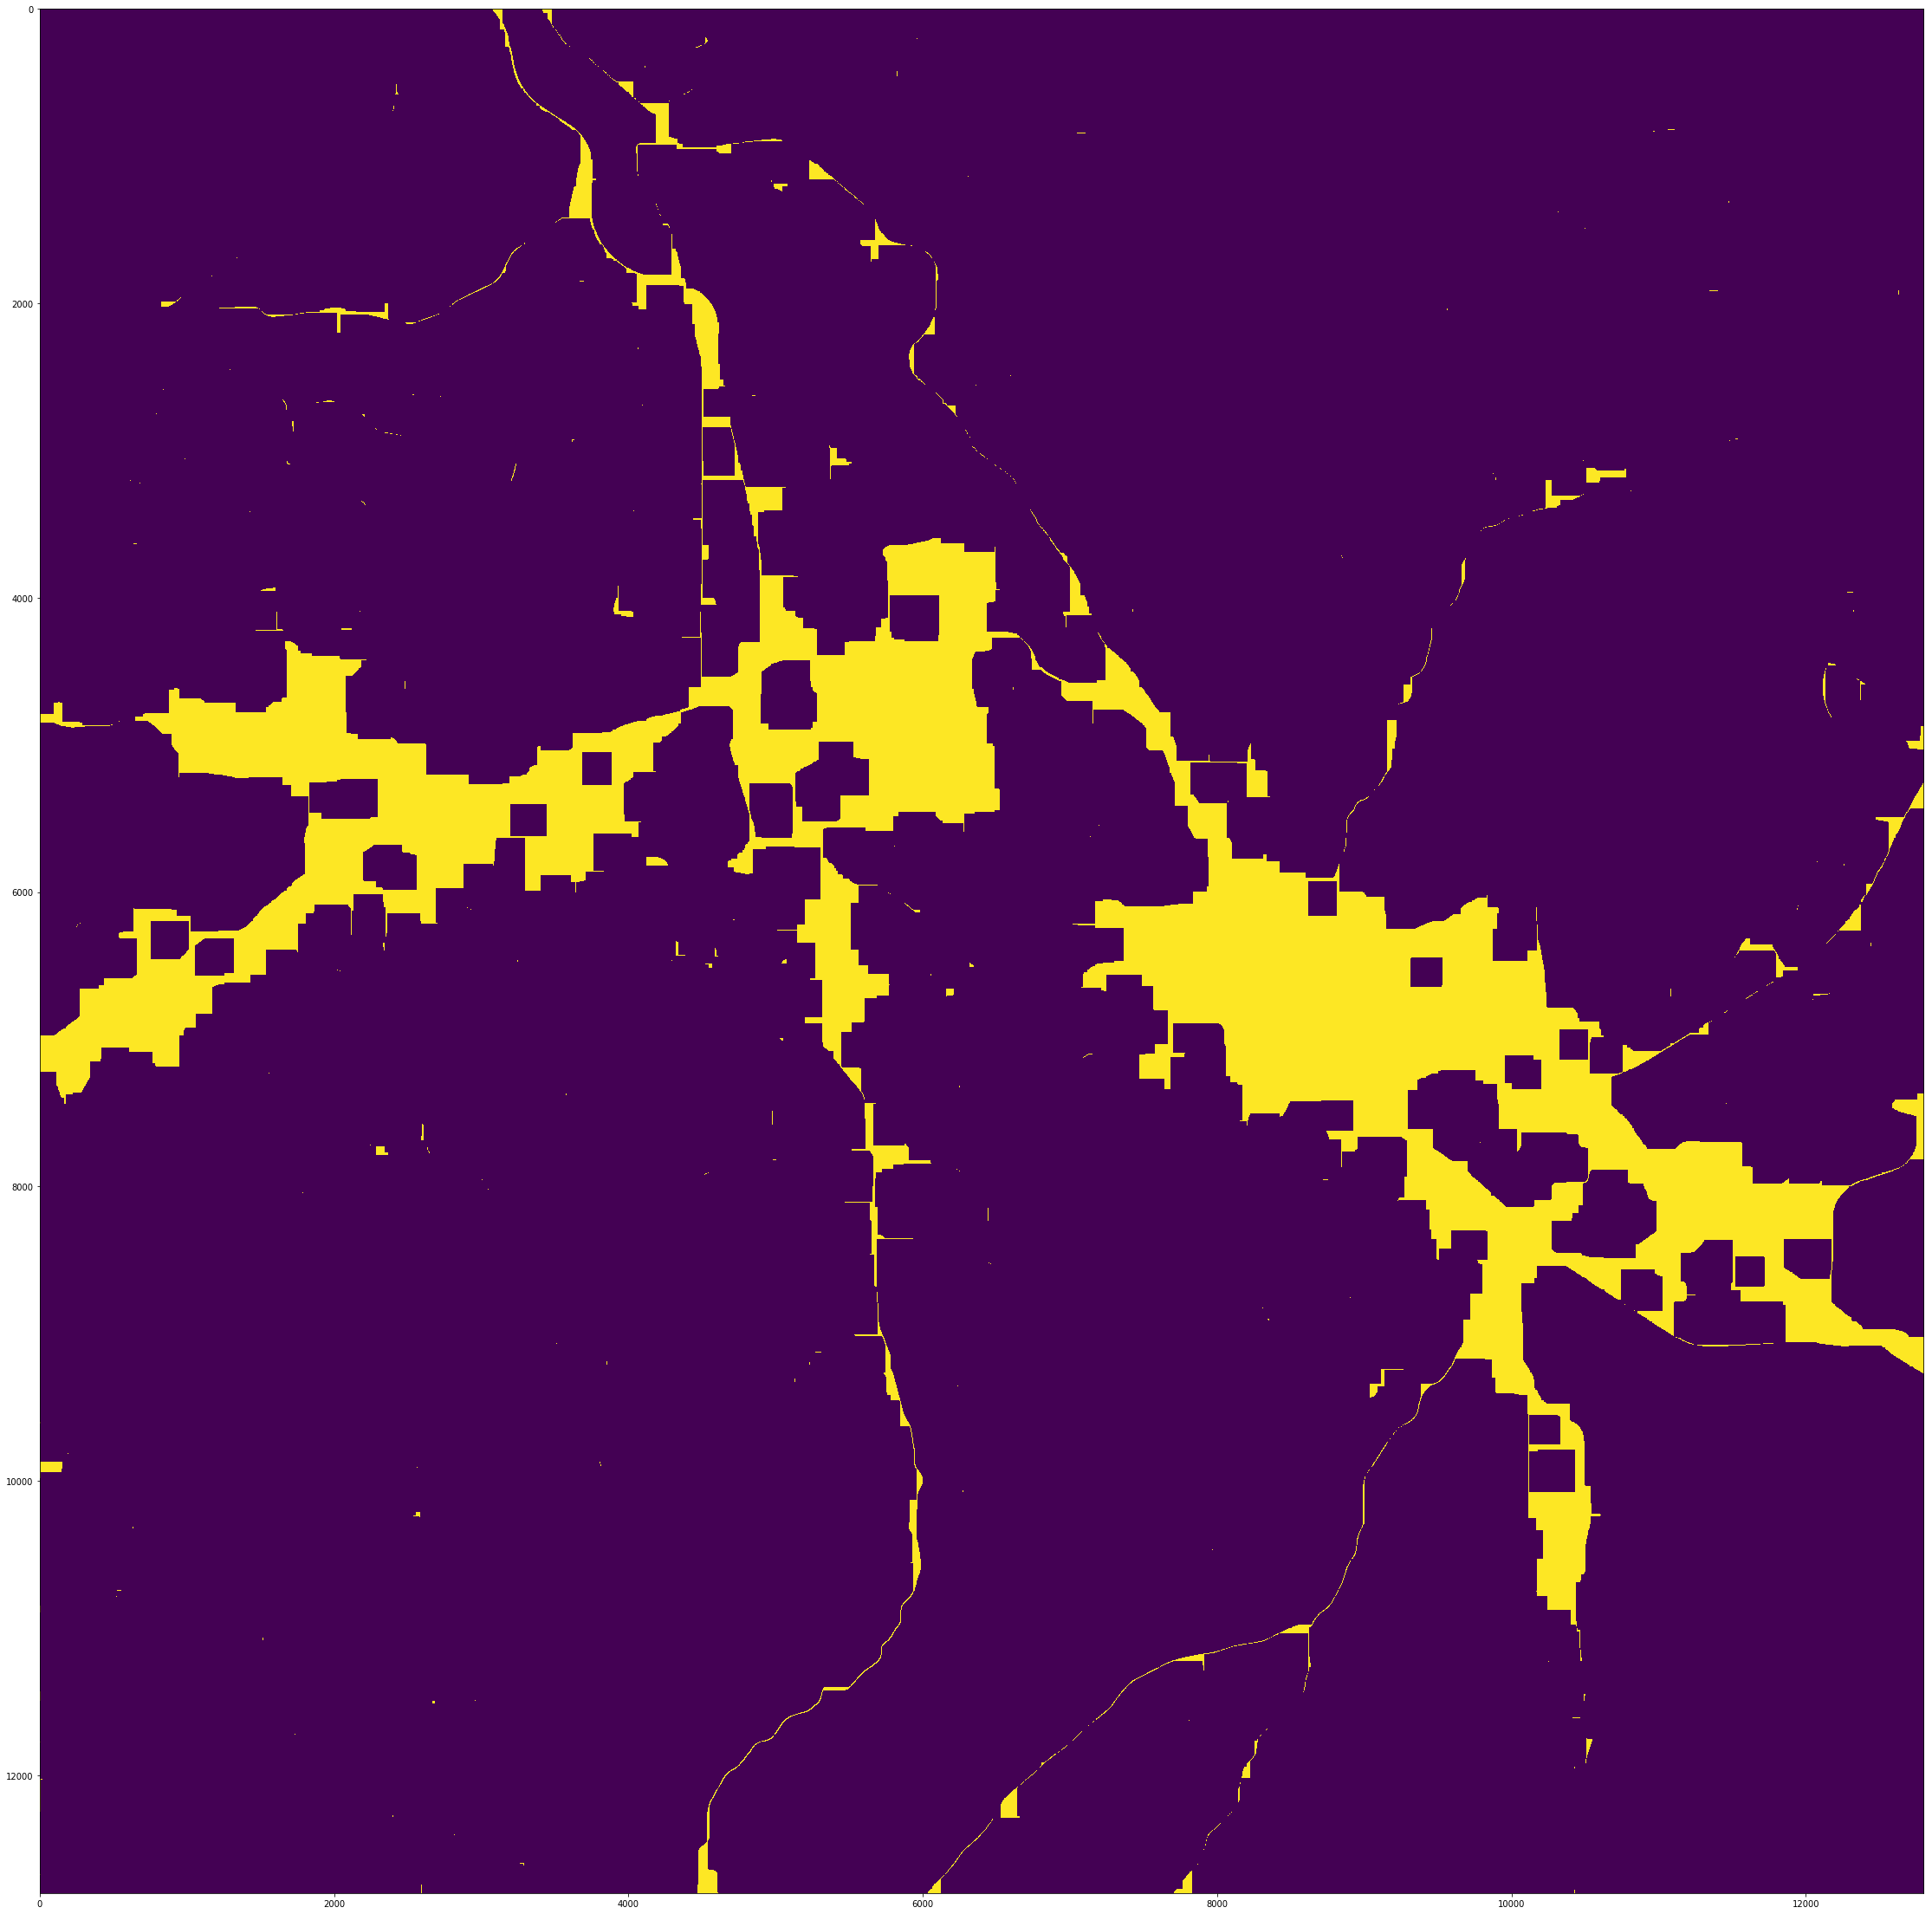

In [42]:
city = 'Globe'
img_path = places[city]['morph']
img = rio_open(img_path)
img = img[:, :, 0]
fig, ax = plt.subplots(1, 1, figsize = (40, 40))
ax.imshow(img)